# Oemof Component Models

**Please note, that this tutorial refers to v:0.3.1 Buggy Battery and its licenced by GPL v3.0. The concept was created by @srhbrnds in Sep 2019**

Component Models in omeof are categorized in three different categories: 
* Basic (oemof.solph.network)
* Components (oemof.solph.components)
* Custom (oemof.solph.custom)

[include figure/ a) generic, for developers, reduced to modelling concept for multiple technology models b) specific, for users, concrete technology model]

## Basic Components

* **Sink:**
object with n-inputs \
examples: demand, excess electricity
![Sink Component](./graphics/components_basic_sink.svg)

### Lets build a Sink component model together in oemof! 
We take the electricity demand (demand_el) as a Sink and assign a fixed output timeseries to it.

To do so, we need to do the initialization first!

**1)** we collect our necessary tools (import packages)

In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import oemof.solph as solph
from oemof.tools import economics
import oemof.outputlib as outputlib
import logging

**2)** we initiaize the EnergySystem in oemof 

In [5]:
# Initialize a timeindex with the help of pandas.date_range() for one year (2017) 
# with hourly time increments

timeindex = pd.date_range('1/1/2017', periods=8760, freq='H')

# Initialize the energy system and hand over the timeindex
es = solph.EnergySystem(timeindex=timeindex)

# Initialize a first node, the electricity bus (bus_el)
bel=solph.Bus(label='bus_el')

es.add(bel)

**3)** read in a data set

In [6]:
# cost dictionary
costs = {'pp_pv': {
             'epc': economics.annuity(capex=750, n=20, wacc=0.05)},
         'pp_diesel': {
             'epc': economics.annuity(capex=300, n=10, wacc=0.05),
             'var': 0}}

**4)** we create a Sink obejct and assign the variable name and specify the label as *demand_el*

In [7]:
demand=solph.Sink(label='demand_el', inputs={bel:solph.Flow()})

if isinstance(demand,solph.Sink):
    print("Congrats you created a Sink object! Add a timeseries to the input Flow object")  
else:
    print("Something went wrong! Try it again")


Congrats you created a Sink object! Add a timeseries to the input Flow object


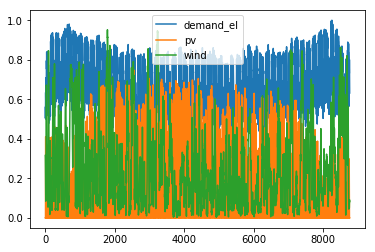

In [8]:
#read in a dataset as pandas DataFrame
data=pd.read_csv('./2_timeseries.csv')
data.plot()

In [9]:
demand=solph.Sink(label='demand_el', inputs={bel:solph.Flow(actual_value=data['demand_el'],
                                                            nominal_value=500, 
                                                            fixed=True)})

# add demand to the EnergySystem 
es.add(demand)


excess_sink = solph.Sink(label='excess',
                    inputs={bel: solph.Flow()})
es.add(excess_sink)

* **Source:**
object with m-outputs
examples: fuel commodities, PV systems

![Source Component](./graphics/components_basic_source.svg)

### Lets build a Source component model together in oemof! 
We model the pv output (pv) as a Source and assign a fixed output timeseries to it.   

**Hint!** You can download RE time series from here: https://www.renewables.ninja/

In [10]:
pv_plant= solph.Source(label='pp_pv',
                 outputs={bel: solph.Flow(nominal_value=None,
                                            fixed=True,
                                            actual_value=data['pv'],
                                            investment=solph.Investment(
                                                ep_costs=costs['pp_pv']['epc']))})

es.add(pv_plant)


* **Transformer:** 
object with n-inputs and m-outputs and an input-output relation

![Transformer Component](./components_basic_transformer_io_relation.svg)

### Lets build a Transformer component model together in oemof! 
We model a diesel generator as a transformer. The gas plant receives diesel from a fuel commodity and transfers it with a constant conversion factor of 33%. 


In [22]:
#add a gas bus as input for the transformer
bfuel=solph.Bus(label='bus_diesel')


fuel_source=solph.Source(label='diesel',outputs={bfuel:solph.Flow()})

genset=solph.Transformer(label="diesel_genset",
                           inputs={bfuel: solph.Flow(variable_costs=0.03)},
                           outputs={bel: solph.Flow(
                               variable_costs=costs['pp_diesel']['var'],
                               investment=solph.Investment(
                                   ep_costs=costs['pp_diesel']['epc']))},
                           conversion_factors={bel: 0.33}
                           )

#You can add multiple components at once
es.add(genset, fuel_source, bfuel)

ValueError: 
Grouping 
  2350983850968:diesel_genset
and
  2351137706376:diesel_genset
collides.
Possibly duplicate uids/labels?

### Solve the energy system model

Now we created a simple microgrid that will be translated into a operational model (m) in the next step and than solved by the open source solver cbc.

In [12]:
print('\n')
logging.info('Initializing model')
m = solph.Model(es)

# m.write(filename, io_options={'symbolic_solver_labels': True})

logging.info('Starting oemof-optimization of capacities')
m.solve(solver='cbc', solve_kwargs={'tee': False})

{'Problem': [{'Name': 'unknown', 'Lower bound': 554298.1523, 'Upper bound': 554298.1523, 'Number of objectives': 1, 'Number of constraints': 52561, 'Number of variables': 52563, 'Number of nonzeros': 118516, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'Termination condition': 'optimal', 'Error rc': 0, 'Time': 3.7475948333740234}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Postprocessing the results

In [17]:
results = outputlib.processing.results(m)

el_bus = outputlib.views.node(results, 'bus_el')
cap_pv = el_bus['scalars'][(('pp_pv', 'bus_el'), 'invest')]
cap_genset = el_bus['scalars'][(('diesel_genset', 'bus_el'), 'invest')]

print('PV capacity in [kW]:' + str(cap_pv))
print('Diesel genset capacity in [kW]:' + str(cap_genset))


PV capacity in [kW]:1464.6981
Diesel genset capacity in [kW]:499.39362


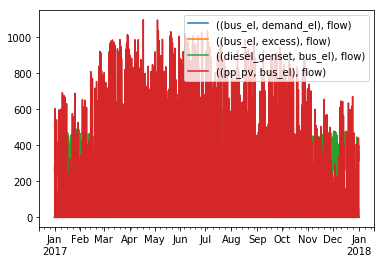

In [21]:
outputlib.views.node(results, 'bus_el')['sequences'].plot(drawstyle='steps')